In [1]:
# Import the python librarys
import numpy as np
import pandas as pd
from io import StringIO
import seaborn as sns; sns.set()
import gzip
import os

import matplotlib
import matplotlib.pyplot as plt

In [2]:
# read meta data
kegg_orgs = pd.read_csv('Kegg_ko_org_matrix_cols_index.txt', sep='\t', header=-1, names=['id', 'name', 'tree', 'tax_id'])
kegg_kos = pd.read_csv('Kegg_ko_org_matrix_rows_index.txt', sep='\t', header=-1, names=['id', 'desc'])

kegg_orgs[['taxa1','taxa2','taxa3','taxa4']]=pd.DataFrame(kegg_orgs.tree.str.split(';',3).tolist(), columns = ['taxa1','taxa2','taxa3','taxa4'])
kegg_orgs['taxa12'] = kegg_orgs[['taxa1', 'taxa2']].apply(lambda x: ';'.join(x), axis=1)
kegg_orgs['taxa123'] = kegg_orgs[['taxa12', 'taxa3']].apply(lambda x: ';'.join(x), axis=1)
kegg_orgs[kegg_orgs['taxa1']=='Eukaryotes'].shape

(356, 10)

In [3]:
print('KEGG Organisms',kegg_orgs.shape)
print('KEGG Orthology',kegg_kos.shape)

KEGG Organisms (4648, 10)
KEGG Orthology (20624, 2)


In [57]:
kegg_orgs[kegg_orgs['id'] == 'mbv']
np.sum(kegg_ko_org_mat[2501,:])

55

In [4]:
# read matrix (from csv)
data = []
with open('Kegg_ko_org_matrix.txt', 'r') as f:
    s = f.read()
    t = s.split('\n')
    for temp in t:
        data.append(list(temp))
kegg_ko_org_mat = np.array(data, dtype=np.uint8)

In [5]:
print('Matrix', kegg_ko_org_mat.shape)
int(kegg_ko_org_mat.shape[0]/64) + 1

Matrix (20624, 4648)


323

(4648,)


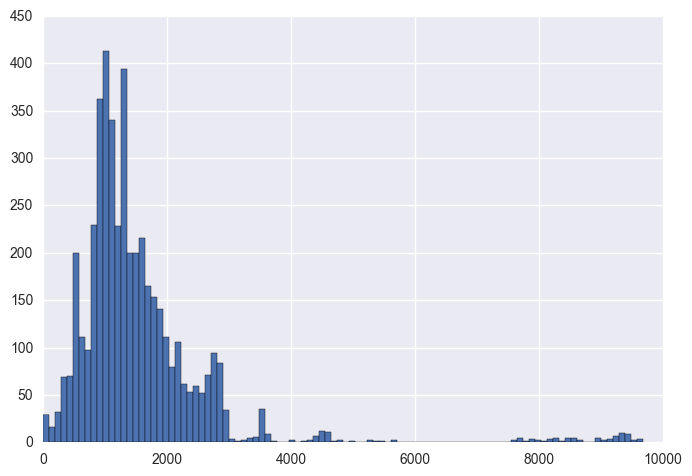

In [6]:
stat = np.sum(kegg_ko_org_mat, axis=0)
print(stat.shape)
plt.close('all')
f, ax = plt.subplots()
ax.hist(stat, 100, histtype='bar')
plt.show()

In [193]:
small_orgs = kegg_orgs.iloc[(stat>200) & (stat<=600)].id.tolist()
len(small_orgs)

400

In [8]:
# read matrix (from gz)
def readGzip(filename):
    input_file = gzip.open(filename, 'rb')
    try:
        nrows = int.from_bytes(input_file.read(4), byteorder='little')
        ncols = int.from_bytes(input_file.read(4), byteorder='little')
        dt = np.dtype(np.uint64)
        dt = dt.newbyteorder('L')
        print('uint64_mat size:', nrows, ncols)
        t = np.frombuffer(input_file.read(), dtype=np.uint64).reshape((nrows, ncols))
    finally:
        input_file.close()
    return nrows, ncols, t

ncols, nrows, kegg_org_mat = readGzip('Kegg_ko_org_matrix.bin.gz')

# verify this is same or not to the original matrix
# uint64_mat.tobytes() == kegg_org_mat.tobytes()

uint64_mat size: 4648 323


In [9]:
# read a result table (binary file)
with open("/Users/leej324/Documents/projects/bsf-kegg/bin_4648_0_0_4648_4648_result_kegg.txt.bin", "rb") as f:
    rst_mat = np.frombuffer(f.read(), dtype=np.uint32).reshape((ncols, ncols))
rst_mat

array([[   0,  817,  787, ...,  846,  356,  387],
       [   0,    0,  689, ...,  702,  313,  320],
       [   0,    0,    0, ...,  667,  286,  323],
       ..., 
       [   0,    0,    0, ...,    0,  333,  359],
       [   0,    0,    0, ...,    0,    0, 2362],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=uint32)

In [10]:
sym_mat = np.zeros((ncols, ncols))
for i in range(ncols):
    for j in range(ncols):
        if i < j:
            sym_mat[i,j] = rst_mat[i,j]
        elif i > j:
            sym_mat[i,j] = rst_mat[j,i]

In [11]:
## correction!!
# we need to eliminate the all 0 columns (organisms having no KO)
nKos = np.sum(kegg_ko_org_mat, axis=0)
deleteIndex = np.where(nKos==0)
mat = np.delete(sym_mat, deleteIndex, 0)
mat = np.delete(mat, deleteIndex, 1)
norgs = mat.shape[0]

_kegg_orgs = kegg_orgs.drop(kegg_orgs.index[deleteIndex])
fixed_kegg_orgs = _kegg_orgs.reset_index(drop=True)

In [12]:
tuples = list(zip(np.array(fixed_kegg_orgs[['taxa1']]).flatten(),
                  np.array(fixed_kegg_orgs[['taxa2']]).flatten(),
                  np.array(fixed_kegg_orgs[['taxa3']]).flatten(),
                  np.array(fixed_kegg_orgs[['taxa4']]).flatten(),
                  np.array(fixed_kegg_orgs[['name']]).flatten(),
                  np.array(fixed_kegg_orgs[['id']]).flatten()))

m_index = pd.MultiIndex.from_tuples(tuples, names=['Lv1', 'Lv2', 'Lv3', 'Lv4', 'name', 'id'])
bigtable = pd.DataFrame(mat, index=m_index, columns=m_index)

Lv1                                                                                                                                             Prokaryotes  \
Lv2                                                                                                                                                Bacteria   
Lv3                                                                                                                                      Betaproteobacteria   
Lv4                                                                                                                                              Acidovorax   
name                                                                                                                                      Acidovorax avenae   
id                                                                                                                                                      aaa   
Lv1         Lv2      Lv3                                  Lv4                    name                                               id                        
Prokaryotes Bacteria Betaproteobacteria                   Acidovorax             Acidovorax avenae                                  aaa                 0.0   
                     Firmicutes - Bacilli                 Alicyclobacillus       Alicyclobacillus acidocaldarius subsp. acidocal... aac               817.0   
                     Actinobacteria                       Acidipropionibacterium Acidipropionibacterium acidipropionici CGMCC 1.... aaci              787.0   
                     Gammaproteobacteria - Others         Aggregatibacter        Aggregatibacter actinomycetemcomitans NUM4039      aacn              833.0   
                     Firmicutes - Bacilli                 Alicyclobacillus       Alicyclobacillus acidocaldarius subsp. acidocal... aad               803.0   
                     Aquificae                            Aquifex                Aquifex aeolicus                                   aae               704.0   
Eukaryotes  Protists Stramenopiles                        Pelagophytes           Aureococcus anophagefferens                        aaf               346.0   
            Animals  Arthropods                           Insects                Aedes aegypti (yellow fever mosquito)              aag               312.0   
Prokaryotes Bacteria Gammaproteobacteria - Others         Aggregatibacter        Aggregatibacter actinomycetemcomitans HK1651       aah               850.0   
                     Actinobacteria                       Glutamicibacter        Glutamicibacter arilaitensis Re117                 aai               826.0   
                     Gammaproteobacteria - Others         Aeromonas              Aeromonas aquatica                                 aaj              1275.0   
                     Alphaproteobacteria                  Aminobacter            Aminobacter aminovorans                            aak              1288.0   
                     Gammaproteobacteria - Others         Alteromonas            Alteromonas australica H 17                        aal              1172.0   
Eukaryotes  Animals  Vertebrates                          Birds                  Apteryx australis mantelli (brown kiwi)            aam               303.0   
Prokaryotes Bacteria Firmicutes - Bacilli                 Anoxybacillus          Anoxybacillus amylolyticus                         aamy              871.0   
                     Gammaproteobacteria - Others         Aggregatibacter        Aggregatibacter actinomycetemcomitans D7S-1        aan               845.0   
                                                                                 Aggregatibacter actinomycetemcomitans ANH9381      aao               859.0   
                                                                                 Aggregatibacter aphrophilus NJ8700                 aap               872.0   
                     Acti

In [194]:
# delete these
# Gammaproteobacteria-Unclassified mealybug symbionts
# Gammaproteobacteria-Unclassified aphid symbionts
small_orgs.remove('senm')
small_orgs.remove('sehc')

smalltb = bigtable.loc[bigtable.index.get_level_values('id').isin(small_orgs),bigtable.columns.get_level_values('id').isin(small_orgs)]

/Users/leej324/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.


In [203]:
smalltb.to_csv('small_genomes.txt', sep='\t')

In [225]:
colormap=plt.get_cmap('Paired')
def drawHeatmapMatrix(table, index_level, filename = 'heatmap.png', cmap = colormap, vmin=None, vmax=None, figsize=(30, 30)):
    plt.close("all")
    # Create a custom palette to identify the networks
    groups = np.unique(table.index.get_level_values(index_level))
    t_pal = sns.diverging_palette(240, 10, n=len(groups))
    t_lut = dict(zip(map(str, groups), t_pal))
    # Convert the palette to vectors that will be drawn on the side of the matrix
    t_colors = pd.Series(table.index.get_level_values(index_level), index=table.columns).map(t_lut)
    # Draw the full plot
    cg = sns.clustermap(table, row_colors=t_colors, linewidths=0, row_cluster=False,col_cluster=False, 
                   col_colors=t_colors, figsize=figsize, cmap=cmap, vmin=vmin, vmax=vmax)
    
    ## customize the labels
    labels = [item.get_text() for item in cg.ax_heatmap.get_yticklabels()]
    total = 0
    for i in range(len(labels)):
        label = labels[i]
        labels[i] = label.split('-',1)[1]
        lv4 = labels[i].rsplit('-', 1)[1]
        nrows, ncols = smalltb.loc[smalltb.index.get_level_values('Lv4')==lv4].shape
        total += nrows
        labels[i] = labels[i] + '(' + str(nrows) + ')'
        labels[i] = labels[i].replace('Enterobacteria-', '')
        labels[i] = labels[i].replace('Others-', '')
        labels[i] = labels[i].replace(' - ', '-')
        labels[i] = labels[i].replace('Unclassified Bathyarchaeota', 'Unclassified')
        labels[i] = labels[i].replace('Unclassified Gammaproteobacteria', 'Unclassified')
        labels[i] = labels[i].replace('Unclassified Clostridiales', 'Unclassified')
        labels[i] = labels[i].replace('Unclassified Deltaproteobacteria', 'Unclassified')
        labels[i] = labels[i].replace('Unclassified Nanohaloarchaea', 'Unclassified')
        labels[i] = labels[i].replace('Unclassified Flavobacteriia', 'Unclassified')
        print(labels[i])

    cg.ax_heatmap.set_yticklabels(labels)
    labels.reverse()
    cg.ax_heatmap.set_xticklabels(labels)
    
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    
    ilist, ilist = np.where(np.isnan(cg.data2d))
    for i in ilist:
        cg.ax_heatmap.add_patch(matplotlib.patches.Rectangle((i+0.1,44-i+0.1),0.8,0.8, fill=False))
        cg.ax_heatmap.plot([i+0.1,i+0.9], [44-i+0.1,44-i+0.9], '-', lw=.5, color = '0.75')
        cg.ax_heatmap.plot([i+0.9,i+0.1], [44-i+0.1,44-i+0.9], '-', lw=.5, color = '0.75')

    cg.savefig(filename)
    plt.show()

Verrucomicrobia-Xiphinematobacter(1)
Tenericutes-Ureaplasma(4)
Tenericutes-Spiroplasma(17)
Tenericutes-Phytoplasma(7)
Tenericutes-Mycoplasma(88)
Tenericutes-Mesoplasma(2)
Tenericutes-Hepatoplasma(1)
Spirochaetes-Treponema(12)
Spirochaetes-Borreliella(17)
Spirochaetes-Borrelia(9)
Other-Saccharibacteria(4)
Gammaproteobacteria-Unclassified(2)
Gammaproteobacteria-Portiera(9)
Gammaproteobacteria-Evansia(1)
Gammaproteobacteria-Coxiella(1)
Gammaproteobacteria-Unclassified Enterobacteria(5)
Gammaproteobacteria-Riesia(1)
Gammaproteobacteria-Moranella(2)
Gammaproteobacteria-Buchnera(17)
Gammaproteobacteria-Blochmannia(4)
Firmicutes-Clostridia-Unclassified(1)
Firmicutes-Bacilli-Lactobacillus(1)
Elusimicrobia-Termite group 1(1)
Deltaproteobacteria-Unclassified(1)
Chlamydiae-Chlamydia(113)
Betaproteobacteria-Zinderia(1)
Betaproteobacteria-Profftella(1)
Bacteroidetes-Uzinura(1)
Bacteroidetes-Unclassified(1)
Bacteroidetes-Sulcia(7)
Bacteroidetes-Cardinium(1)
Bacteroidetes-Blattabacterium(8)
Bacteroid

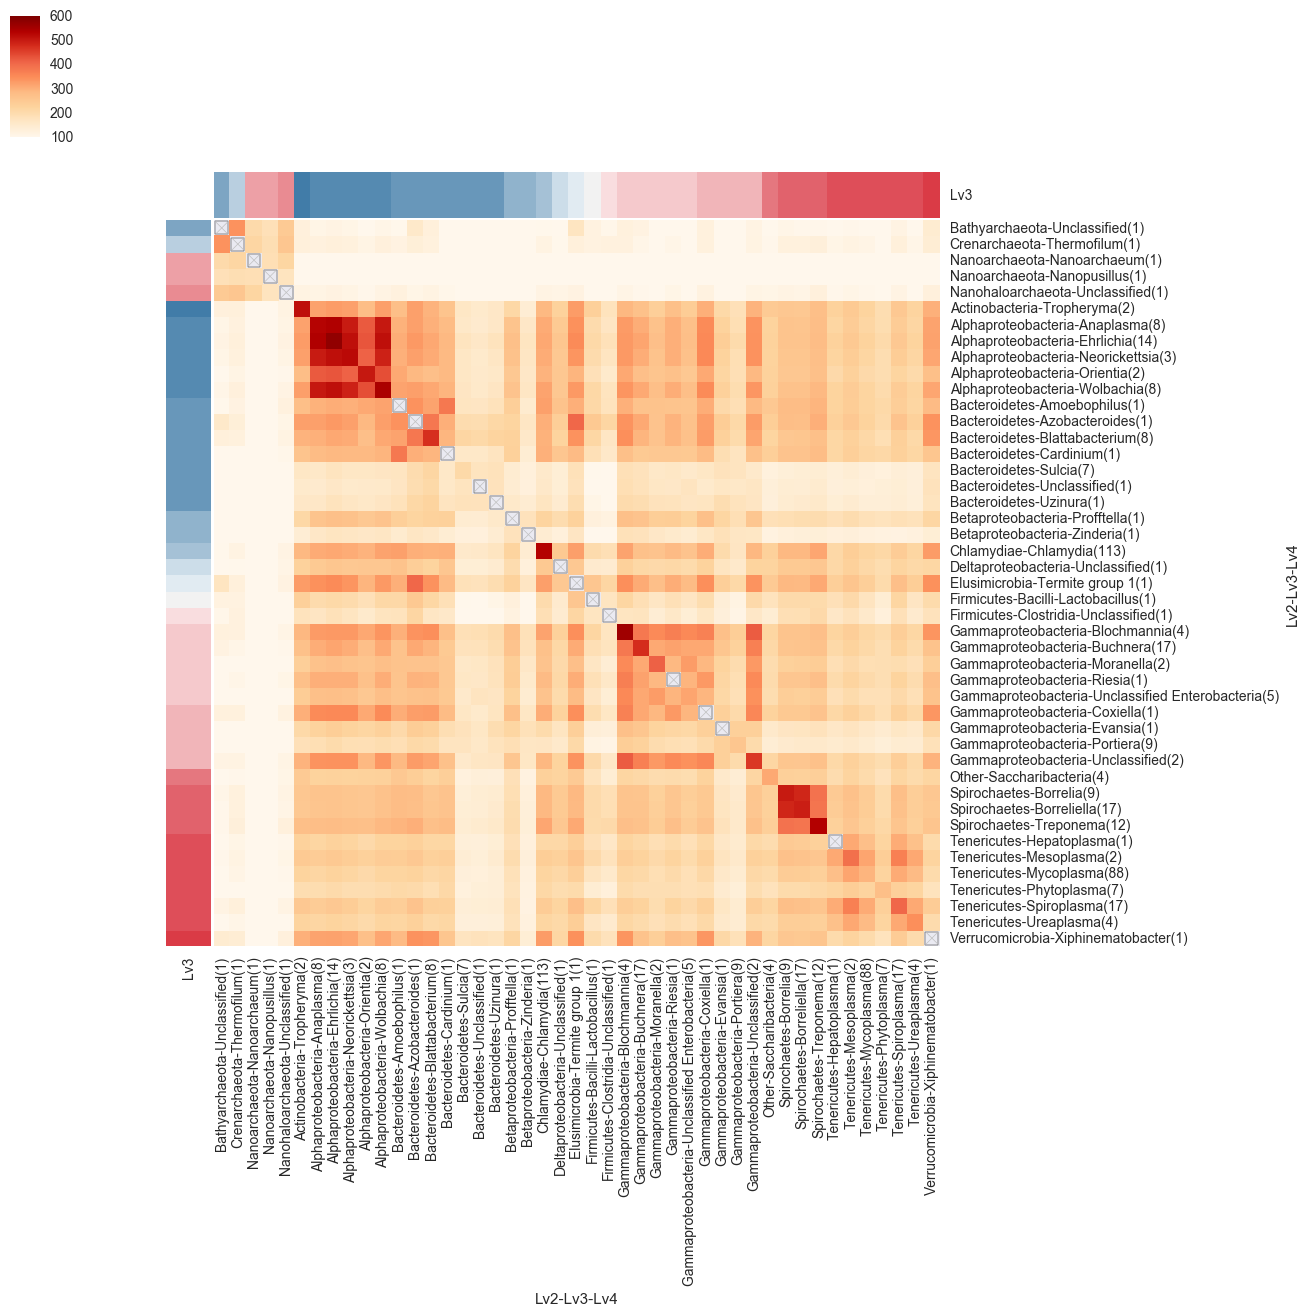

In [226]:
# to avoid the wrong calculation because of the diagonal terms
np.fill_diagonal(smalltb.values, np.nan)

grouped = smalltb.groupby(level=[1,2,3]).mean()
grouped = grouped.groupby(level=[1,2,3], axis=1).mean()

drawHeatmapMatrix(grouped, 'Lv3', 'overall_heatmap_200_600.png', plt.get_cmap('OrRd'),vmin=100, vmax=600, figsize=(12,12))